![image.png](https://i.imgur.com/a3uAqnb.png)

# 🎨 Image Generation using Generative Adversarial Networks (GANs)

GANs were invented in 2014 by Ian Goodfellow. They are a framework for teaching a deep learning model to capture the training data's distribution. They are made of two distinct models, a **Generator** and a **Discriminator**.

- 👨‍🎨 **The Generator's** job is to create 'fake' images that look like the training images.
- 🕵️‍♂️ **The Discriminator's** job is to look at an image and determine if it is a real training image or a fake image from the generator.

During training, the generator constantly tries to outsmart the discriminator by generating better and better fakes, while the discriminator works to become a better detective. The equilibrium of this game is when the generator is creating perfect fakes, and the discriminator is left to guess at 50% confidence whether the output is real or fake.

![gan image](https://i.imgur.com/Ed5ZMfR.png)

<p align = "center">
Fig.1 - GAN Architecture  
(<a href="https://github.com/JamesAllingham/LaTeX-TikZ-Diagrams">
source
</a>)
</p>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize, Normalize
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
import kagglehub
from PIL import Image
import os
from glob import glob

## ⚙️ Hyperparameters and Setup
Here we define the key parameters for our model and training process.

In [2]:
EPOCHS = 20
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
Z = 100  # Increased latent dimension for more complex images
IMAGE_SIZE = 64  # Standard size for anime faces

## 🖼️ Loading the Anime Face Dataset

We'll use a dataset of anime faces from Kaggle. This dataset contains thousands of colorful, high-quality anime character portraits, making it a great choice for training a GAN.

### 🔹 **Dataset Details:**
- **Source**: `splcher/animefacedataset` from Kaggle
- **Content**: A large collection of anime faces.
- **Challenge**: Learning the complex distribution of facial features, hair styles, and colors.
- **Preprocessing**: Resize to a uniform `64x64` and normalize pixel values to `[-1, 1]`.

In [3]:
# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")
print("Path to dataset files:", path)

Path to dataset files: /home/ali/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3


In [4]:
# Custom dataset class for anime faces
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Get all image files
        self.image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_files.extend(glob(os.path.join(root_dir, '**', ext), recursive=True))
        print(f"Found {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, 0  # Return 0 as dummy label

### 🔹 **Image Preprocessing Pipeline**
We define a series of transformations to prepare the images for our network:
1.  **Resize**: Standardize all images to `64x64` pixels.
2.  **ToTensor**: Convert images from PIL format to PyTorch tensors.
3.  **Normalize**: Shift the pixel value range from `[0, 1]` to `[-1, 1]`. This is crucial because the generator's final activation layer is `Tanh`, which outputs values in this range.

In [5]:
# Define transforms for RGB images
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create dataset and dataloader
anime_dataset = AnimeFaceDataset(path, transform=transform)
train_dataloader = DataLoader(anime_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Found 63565 images


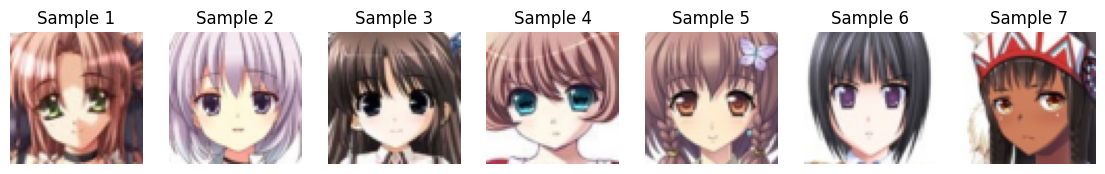

In [6]:
# Visualizing some sample images
figure = plt.figure(figsize=(14, 14))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(anime_dataset), size=(1,)).item()
    img, label = anime_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Sample {i}")
    plt.axis("off")
    # Convert from [-1,1] to [0,1] for display and transpose for matplotlib
    img_display = (img + 1) / 2
    img_display = img_display.permute(1, 2, 0)  # CHW to HWC
    plt.imshow(img_display)
plt.show()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Building the GAN Models

GANs consist of two neural networks, a **Generator** and a **Discriminator**, trained in an adversarial process. GANs are notoriously hard to train, so we will follow some of the best practices from the original DCGAN paper to stabilize training:

- **Weight Initialization**: Initialize weights from a Normal distribution with `mean=0`, `stdev=0.02`.
- **Activations**: Use `ReLU` in the generator (except for the output which uses `Tanh`) and `LeakyReLU` in the discriminator.
- **Optimizer**: Use the `Adam` optimizer with `beta1=0.5`.

--- 

### 👨‍🎨 The Generator

The Generator's job is to create believable images from random noise. It takes a latent vector (`Z`) and upsamples it to produce a `64x64` color image.

**Architecture:**
1.  **Input**: A 100-dimensional noise vector `Z`.
2.  **Upsampling**: A series of `ConvTranspose2d` layers are used to progressively upsample the vector into a 2D image. Each `ConvTranspose2d` layer doubles the image dimensions.
3.  **Normalization**: `BatchNorm` layers are used after each upsampling step to stabilize training.
4.  **Output**: A `Tanh` activation function ensures the output image pixels are in the range `[-1, 1]`, matching our normalized input data.

--- 

### 🕵️‍♂️ The Discriminator

The Discriminator's job is to act as a detective, classifying images as either real (from the dataset) or fake (from the generator).

**Architecture:**
1.  **Input**: A `64x64x3` image.
2.  **Downsampling**: A series of `Conv2d` layers with a `stride` of 2 are used to downsample the image, extracting features at each step.
3.  **Activations**: `LeakyReLU` is used to prevent "[dying ReLU](https://arxiv.org/pdf/1903.06733)" problems and allow gradients to flow, which is crucial for the generator to learn.
4.  **Output**: A `Sigmoid` activation function squashes the final output to a single value between 0 (fake) and 1 (real).

In [8]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)


def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
class Generator(nn.Module):
    """Generator model for RGB images"""
    def __init__(self, z):
        super(Generator, self).__init__()
        self.z = z
        self.gen_model = nn.Sequential(
            # Input: Z latent vector
            nn.Linear(z, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True),
            
            Reshape((-1, 512, 4, 4)),
            
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # 3 channels for RGB
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen_model(x)



class Discriminator(nn.Module):
    """Discriminator model for RGB images"""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc_model = nn.Sequential(
            # 64x64 -> 32x32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # 3 input channels for RGB
            nn.LeakyReLU(0.2, inplace=True),
            
            # 32x32 -> 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16 -> 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8 -> 4x4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 4x4 -> 1x1
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc_model(x).view(-1, 1).squeeze(1)

In [9]:
generator = Generator(z=Z)
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (disc_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
# Generator summary
summary(generator, (Z,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
       BatchNorm1d-2                 [-1, 8192]          16,384
              ReLU-3                 [-1, 8192]               0
           Reshape-4            [-1, 512, 4, 4]               0
   ConvTranspose2d-5            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-6            [-1, 256, 8, 8]             512
              ReLU-7            [-1, 256, 8, 8]               0
   ConvTranspose2d-8          [-1, 128, 16, 16]         524,288
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
  ConvTranspose2d-11           [-1, 64, 32, 32]         131,072
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
  ConvTranspose2d-14            [-1, 3,

In [11]:
# Discriminator summary
summary(discriminator, (3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

### 🎯 Loss Function and Optimizers

- **Loss**: We use **Binary Cross-Entropy Loss** (`BCELoss`). This loss is perfect for the discriminator's task, which is a binary classification problem: is the image real (1) or fake (0)?
- **Optimizers**: We use the `Adam` optimizer for both networks, as recommended, with a `beta1` of 0.5 to help stabilize training.

In [12]:
# Defining the optimizer and loss function here
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [13]:
real_label = 1
fake_label = 0

In [14]:
def display_image_grid(images, num_rows, num_cols, title_text):
    fig = plt.figure(figsize=(num_cols*3., num_rows*3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        # Convert from CHW to HWC and ensure values are in [0,1]
        if len(im.shape) == 3:
            im = im.permute(1, 2, 0)
        im = torch.clamp(im, 0, 1)
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()


## 🚀 Training the GAN

The training process is a delicate, two-part dance. In each iteration, we alternate between training the discriminator and the generator.

### Step 1: Train the Discriminator 🕵️‍♂️
The discriminator's goal is to get better at distinguishing real images from fakes. Its total loss is the sum of its performance on real and fake images.
$$ \nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^{m} [\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))] $$
- We feed it a batch of **real images** and train it to classify them as `real` (label=1).
- We then feed it a batch of **fake images** (generated by the generator) and train it to classify them as `fake` (label=0).

### Step 2: Train the Generator 👨‍🎨
The generator's goal is to fool the discriminator. It wants the discriminator to classify its fake images as real.
$$ \nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^{m} \log(D(G(z^{(i)}))) $$
- We generate a new batch of **fake images**.
- We pass them through the discriminator, but this time, we use `real` labels (label=1).
- We calculate the loss and backpropagate it to update **only the generator's weights**.

In [15]:
sample_noise = torch.randn(7, Z).to(device)


Epoch 1/20: : 100%|██████████| 994/994 [00:17<00:00, 55.60it/s, generator_loss=3.78, discriminator_loss=0.352, D(x)=0.82, D(G(z1))=0.0517, D(G(z2))=0.0311]        


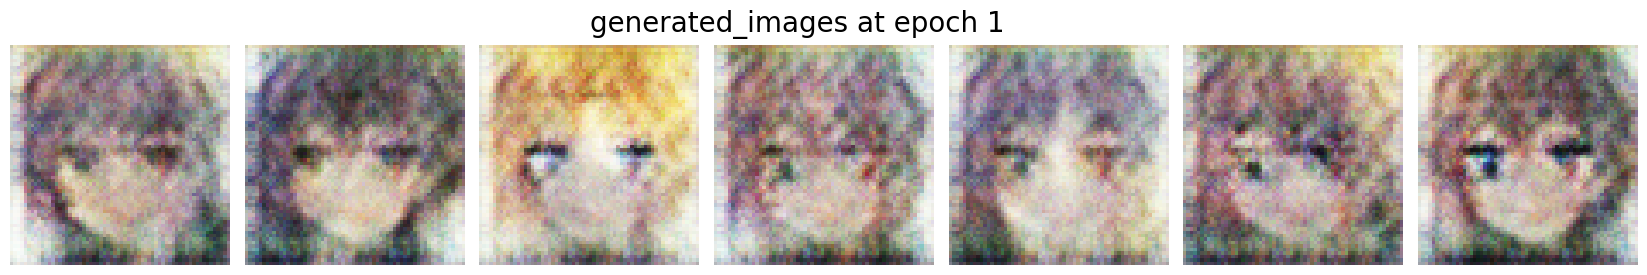

Epoch 2/20: : 100%|██████████| 994/994 [00:14<00:00, 68.25it/s, generator_loss=4.21, discriminator_loss=0.939, D(x)=0.703, D(G(z1))=0.184, D(G(z2))=0.0691]      


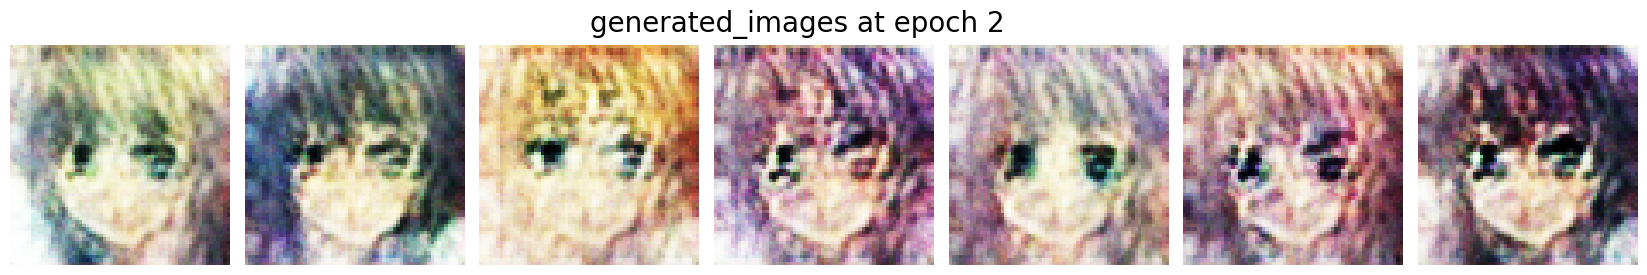

Epoch 3/20: : 100%|██████████| 994/994 [00:14<00:00, 68.15it/s, generator_loss=5.3, discriminator_loss=0.219, D(x)=0.879, D(G(z1))=0.0306, D(G(z2))=0.0105]     


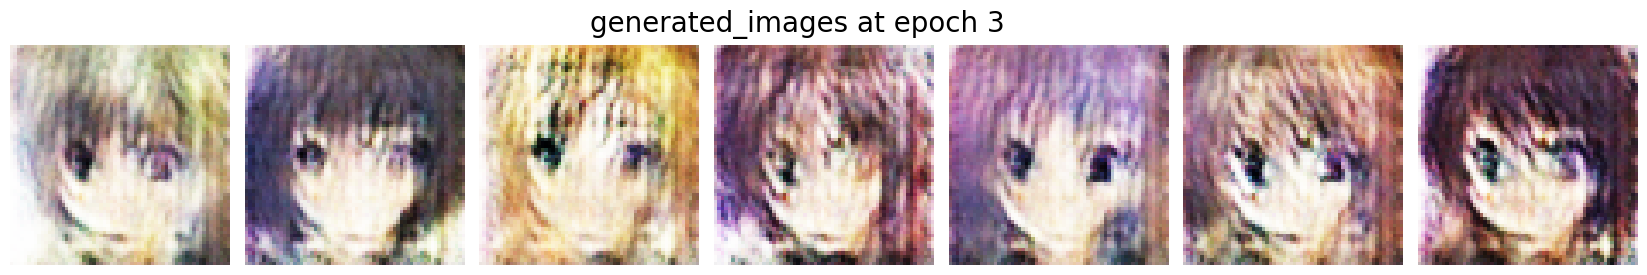

Epoch 4/20: : 100%|██████████| 994/994 [00:14<00:00, 67.80it/s, generator_loss=3.74, discriminator_loss=0.266, D(x)=0.865, D(G(z1))=0.0172, D(G(z2))=0.0308]     


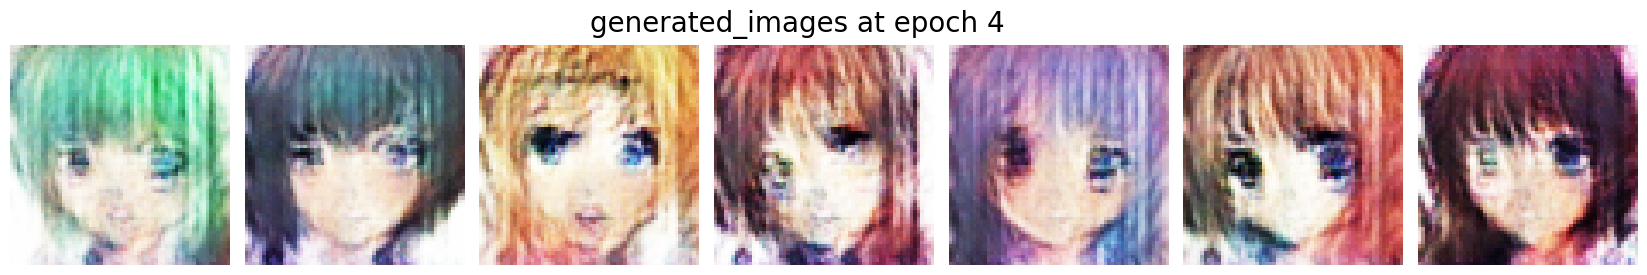

Epoch 5/20: : 100%|██████████| 994/994 [00:14<00:00, 67.86it/s, generator_loss=5.59, discriminator_loss=0.0893, D(x)=0.975, D(G(z1))=0.0594, D(G(z2))=0.00526]  


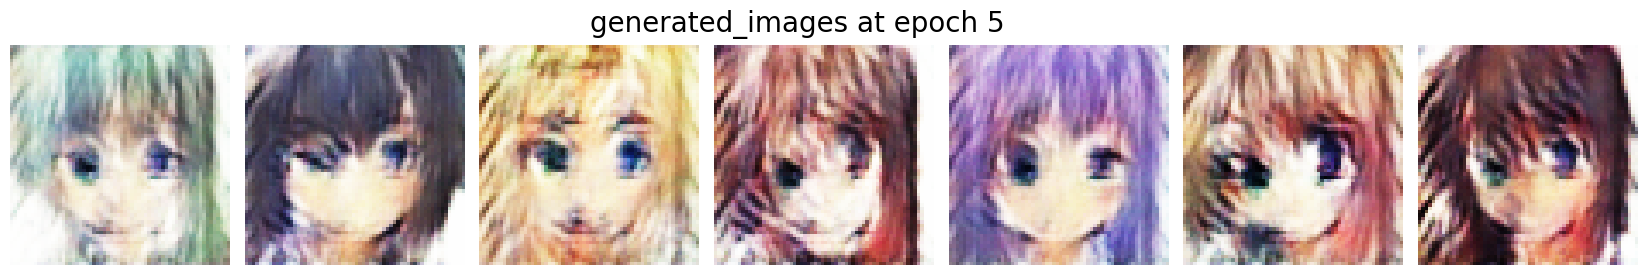

Epoch 6/20: : 100%|██████████| 994/994 [00:15<00:00, 65.13it/s, generator_loss=5.2, discriminator_loss=0.18, D(x)=0.895, D(G(z1))=0.0135, D(G(z2))=0.0133]      


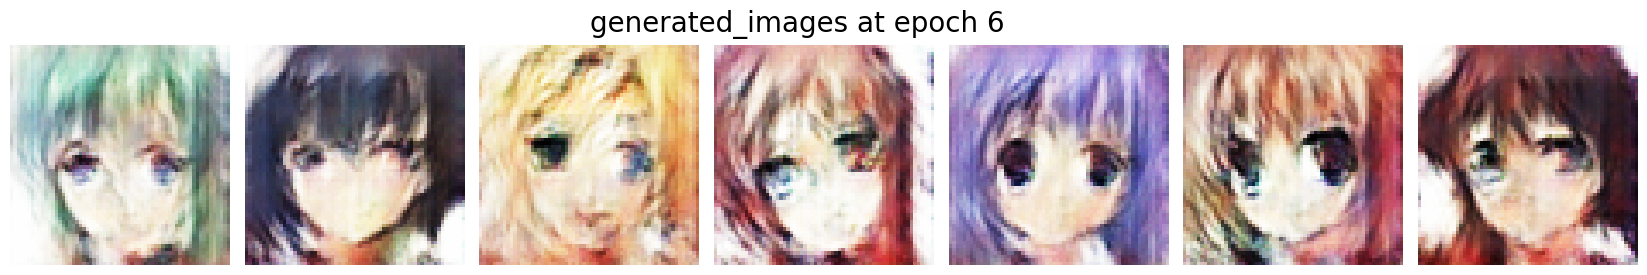

Epoch 7/20: : 100%|██████████| 994/994 [00:15<00:00, 64.30it/s, generator_loss=7.18, discriminator_loss=0.106, D(x)=0.918, D(G(z1))=0.0153, D(G(z2))=0.0022]    


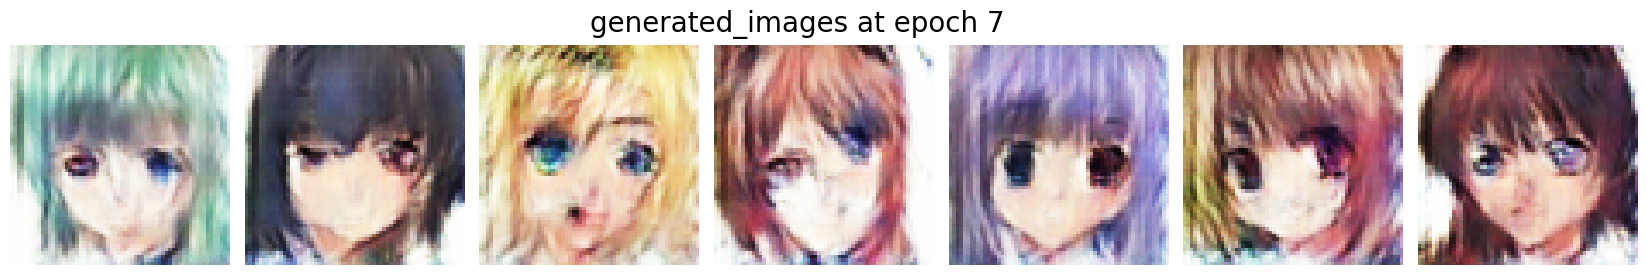

Epoch 8/20: : 100%|██████████| 994/994 [00:15<00:00, 65.89it/s, generator_loss=6.93, discriminator_loss=0.139, D(x)=0.925, D(G(z1))=0.0434, D(G(z2))=0.00221]   


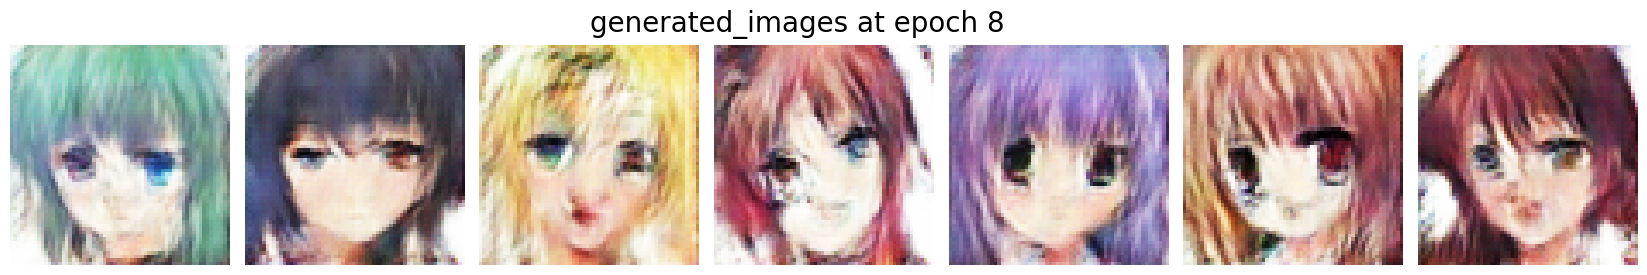

Epoch 9/20: : 100%|██████████| 994/994 [00:15<00:00, 65.18it/s, generator_loss=6.73, discriminator_loss=0.0471, D(x)=0.961, D(G(z1))=0.00554, D(G(z2))=0.00219] 


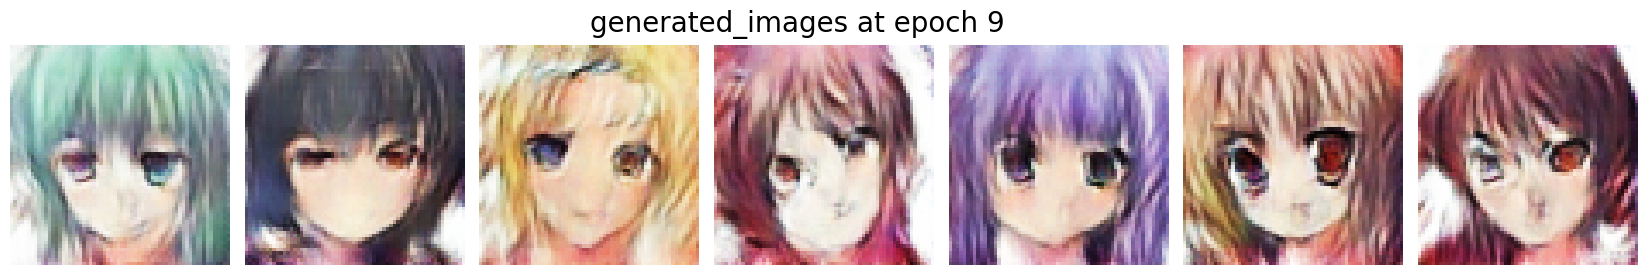

Epoch 10/20: : 100%|██████████| 994/994 [00:15<00:00, 65.79it/s, generator_loss=6.21, discriminator_loss=0.402, D(x)=0.866, D(G(z1))=0.176, D(G(z2))=0.00565]    


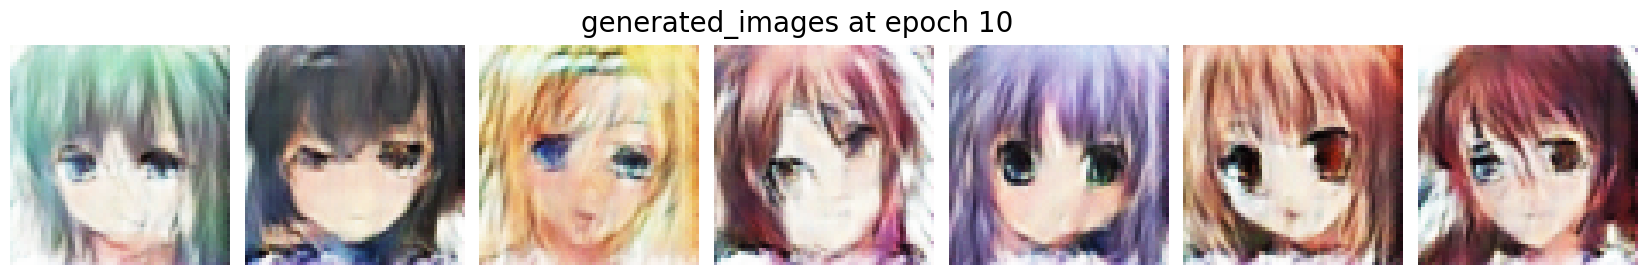

Epoch 11/20: : 100%|██████████| 994/994 [00:15<00:00, 63.96it/s, generator_loss=6.83, discriminator_loss=0.339, D(x)=0.952, D(G(z1))=0.17, D(G(z2))=0.00181]     


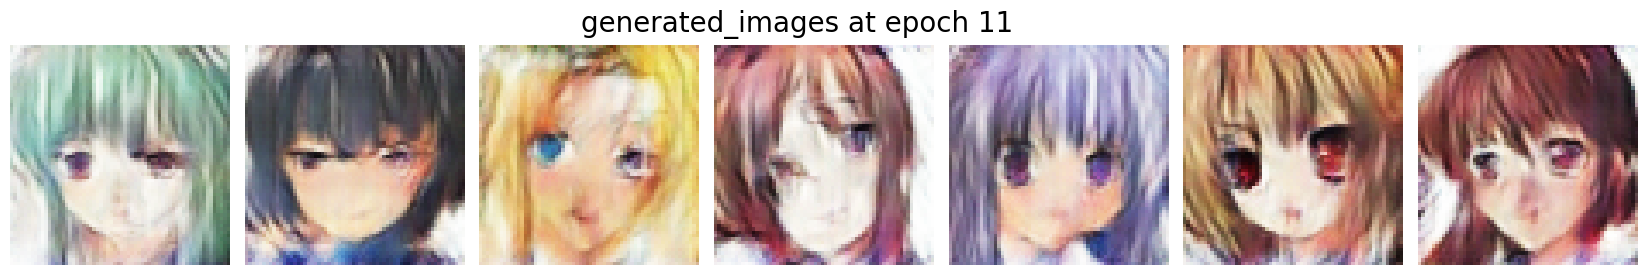

Epoch 12/20: : 100%|██████████| 994/994 [00:15<00:00, 65.52it/s, generator_loss=3.57, discriminator_loss=0.155, D(x)=0.93, D(G(z1))=0.0667, D(G(z2))=0.039]     


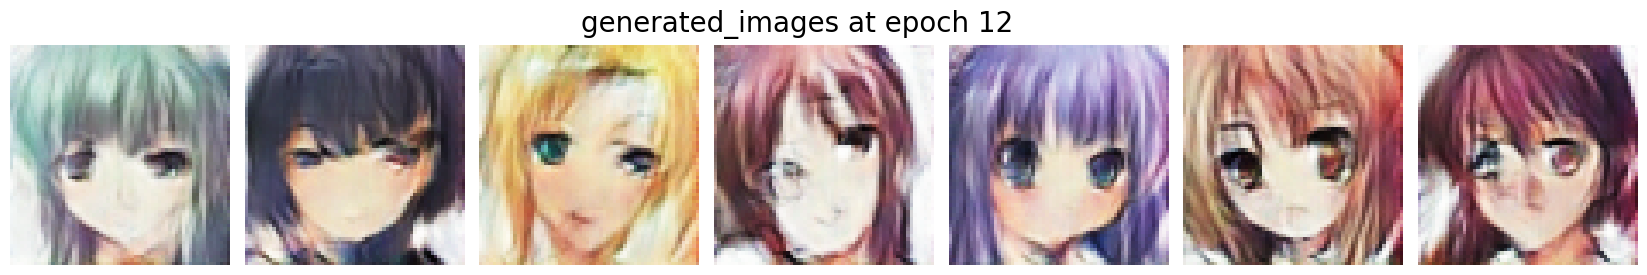

Epoch 13/20: : 100%|██████████| 994/994 [00:15<00:00, 65.44it/s, generator_loss=6.57, discriminator_loss=0.141, D(x)=0.885, D(G(z1))=0.00559, D(G(z2))=0.00303] 


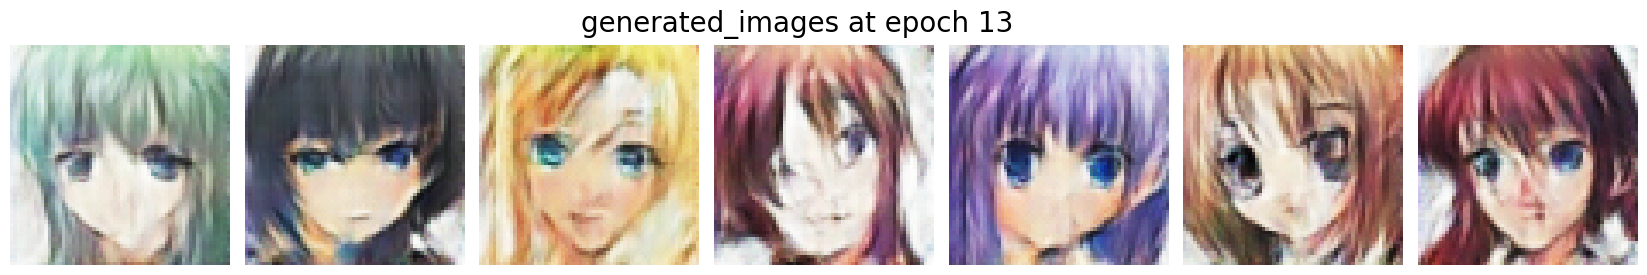

Epoch 14/20: : 100%|██████████| 994/994 [00:15<00:00, 64.66it/s, generator_loss=4.7, discriminator_loss=0.0599, D(x)=0.965, D(G(z1))=0.0221, D(G(z2))=0.015]    


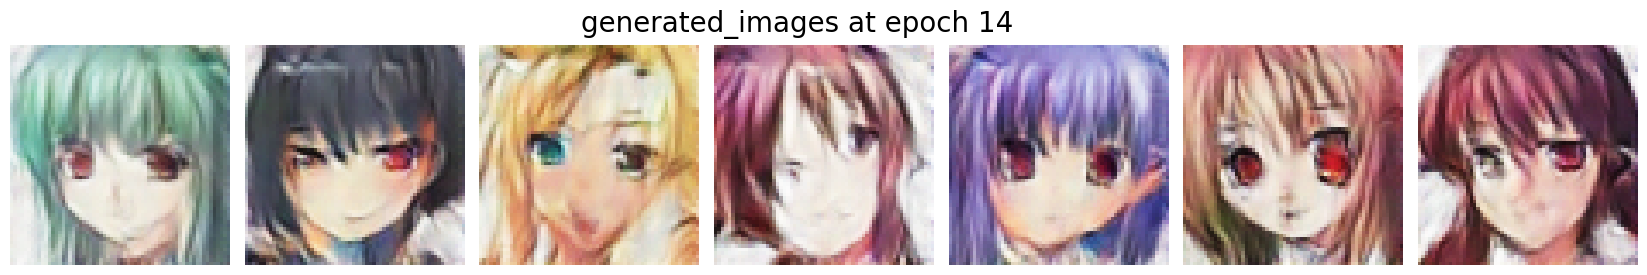

Epoch 15/20: : 100%|██████████| 994/994 [00:15<00:00, 64.10it/s, generator_loss=3.48, discriminator_loss=0.304, D(x)=0.8, D(G(z1))=0.00506, D(G(z2))=0.0557]     


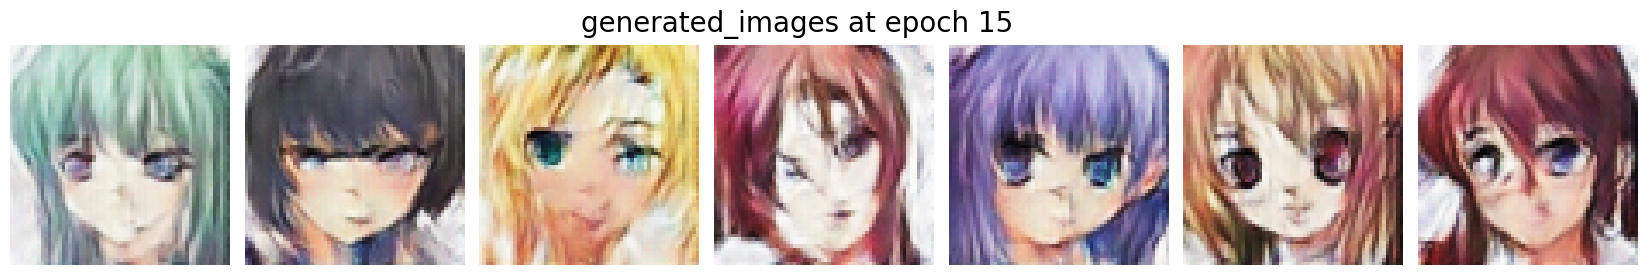

Epoch 16/20: : 100%|██████████| 994/994 [00:15<00:00, 64.30it/s, generator_loss=3.28, discriminator_loss=0.0999, D(x)=0.922, D(G(z1))=0.0156, D(G(z2))=0.0477]  


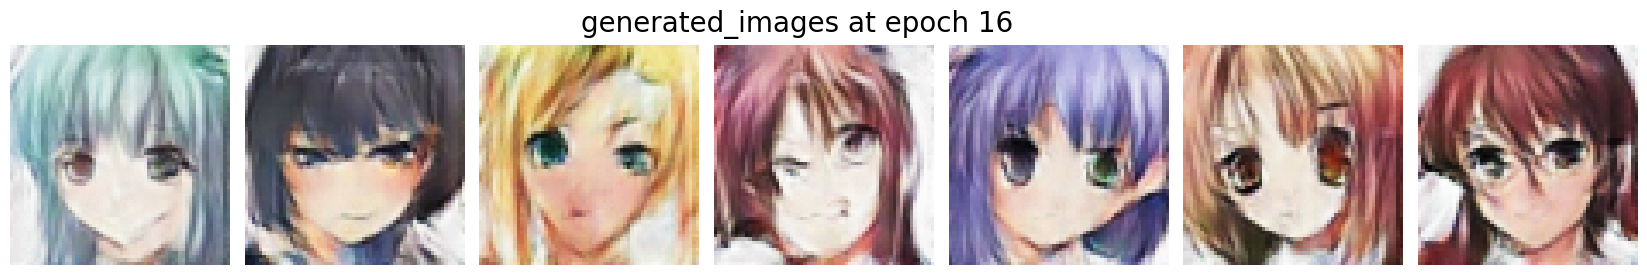

Epoch 17/20: : 100%|██████████| 994/994 [00:15<00:00, 64.27it/s, generator_loss=4.56, discriminator_loss=0.278, D(x)=0.986, D(G(z1))=0.211, D(G(z2))=0.0125]    


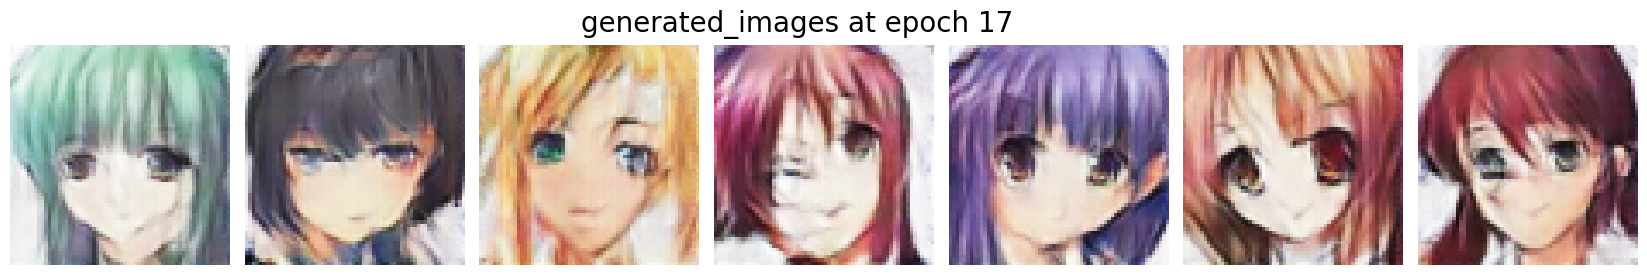

Epoch 18/20: : 100%|██████████| 994/994 [00:15<00:00, 64.18it/s, generator_loss=5.7, discriminator_loss=0.00733, D(x)=0.998, D(G(z1))=0.00566, D(G(z2))=0.00477] 


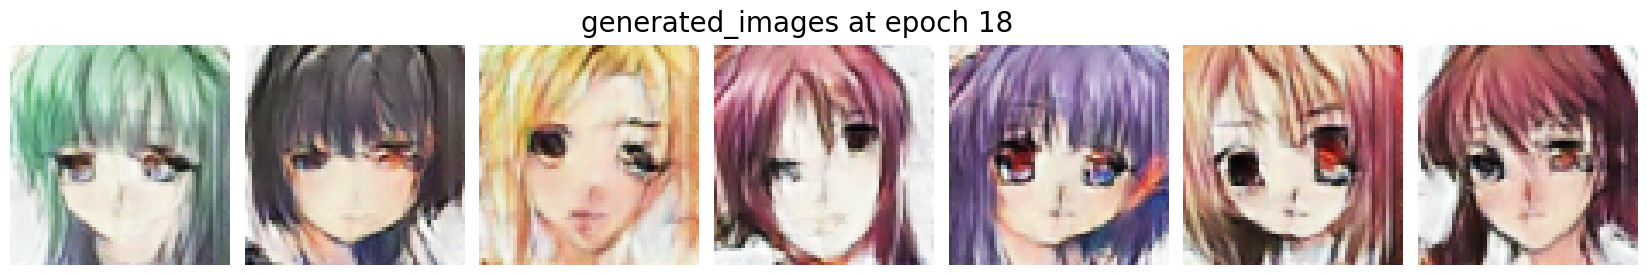

Epoch 19/20: : 100%|██████████| 994/994 [00:15<00:00, 64.04it/s, generator_loss=4.76, discriminator_loss=0.0482, D(x)=0.987, D(G(z1))=0.0343, D(G(z2))=0.0126]  


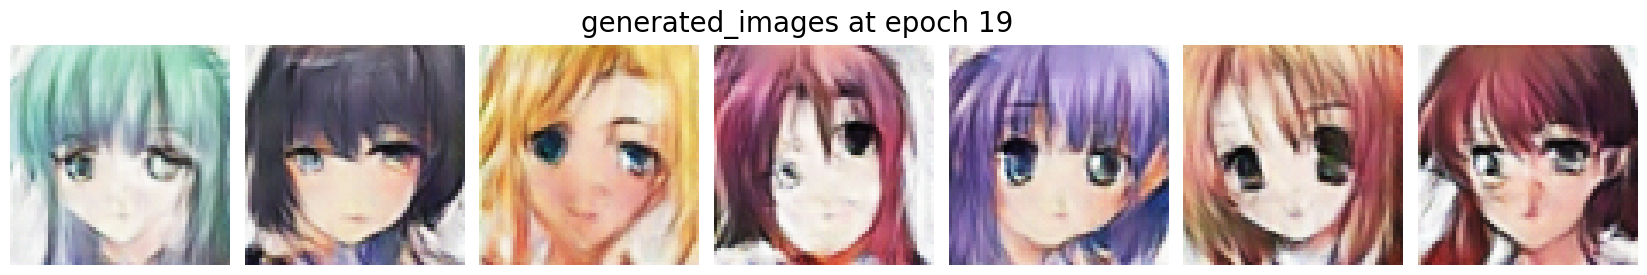

Epoch 20/20: : 100%|██████████| 994/994 [00:16<00:00, 61.99it/s, generator_loss=4.26, discriminator_loss=0.133, D(x)=0.906, D(G(z1))=0.0234, D(G(z2))=0.0295]   


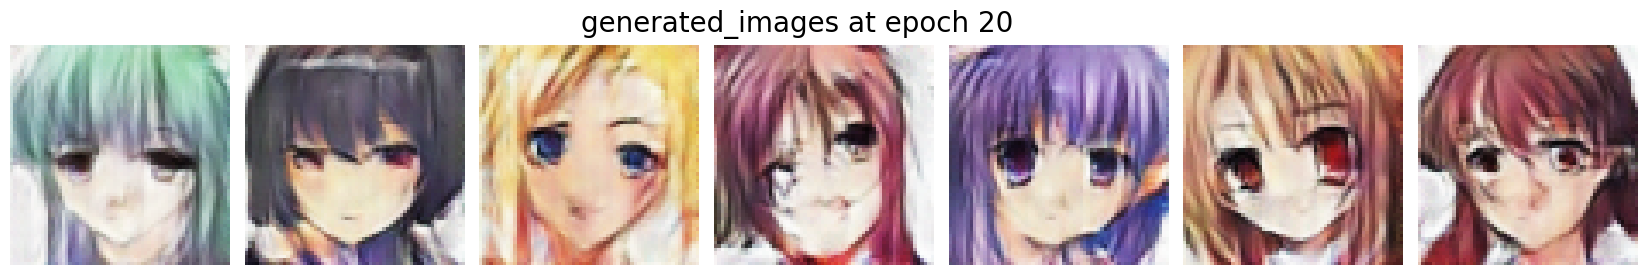

In [16]:
# Lists to keep track of progress
G_losses = []
D_losses = []

for i in range(1, EPOCHS+1):
    pbar = tqdm(train_dataloader)
    for b, data in enumerate(pbar):
        # Every data instance is an input + label pair. We don't need the label
        inputs, _ = data
        inputs = inputs.to(device)
        # Data is already normalized to [-1,1] by transform

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        discriminator.zero_grad()
        # Set up labels
        label = torch.full((inputs.shape[0],), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(inputs)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(inputs.shape[0], Z, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizer_disc.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_gen.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"generator_loss": errG.item(), "discriminator_loss": errD.item(), "D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2})

    with torch.no_grad():
        generations = generator(sample_noise).cpu()
        generations = (generations + 1) / 2  # setting generations range to [0,1] 
    display_image_grid(generations, 1, 7, f"generated_images at epoch {i}")


### 📈 Training Loss Visualization

Plotting the losses helps us understand the dynamics of the adversarial training. 
- **Discriminator Loss (D)**: Ideally, this should hover around 0.5. If it goes to 0, the generator isn't learning.
- **Generator Loss (G)**: We want to see this loss decrease, indicating the generator is getting better at fooling the discriminator.

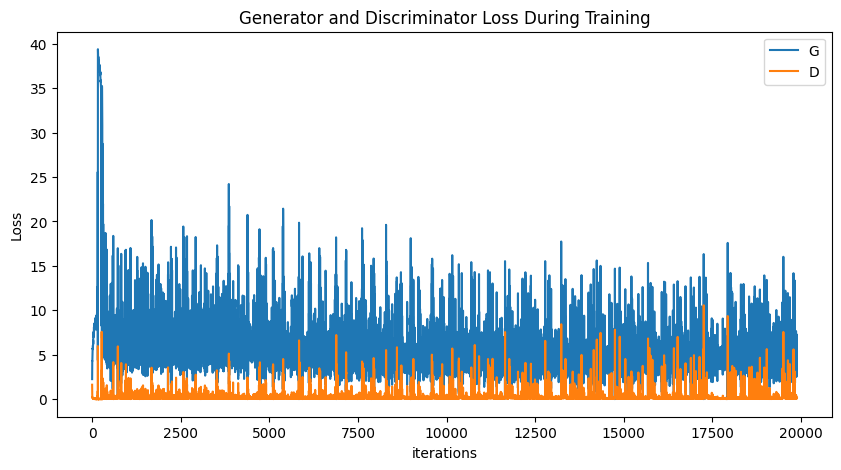

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# Set the generator to eval state
generator.eval()

Generator(
  (gen_model): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Reshape()
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (14): Tanh()

### ✨ Generation through GANs

Now that training is complete, we can use our generator to create new, unique anime faces from random noise vectors.

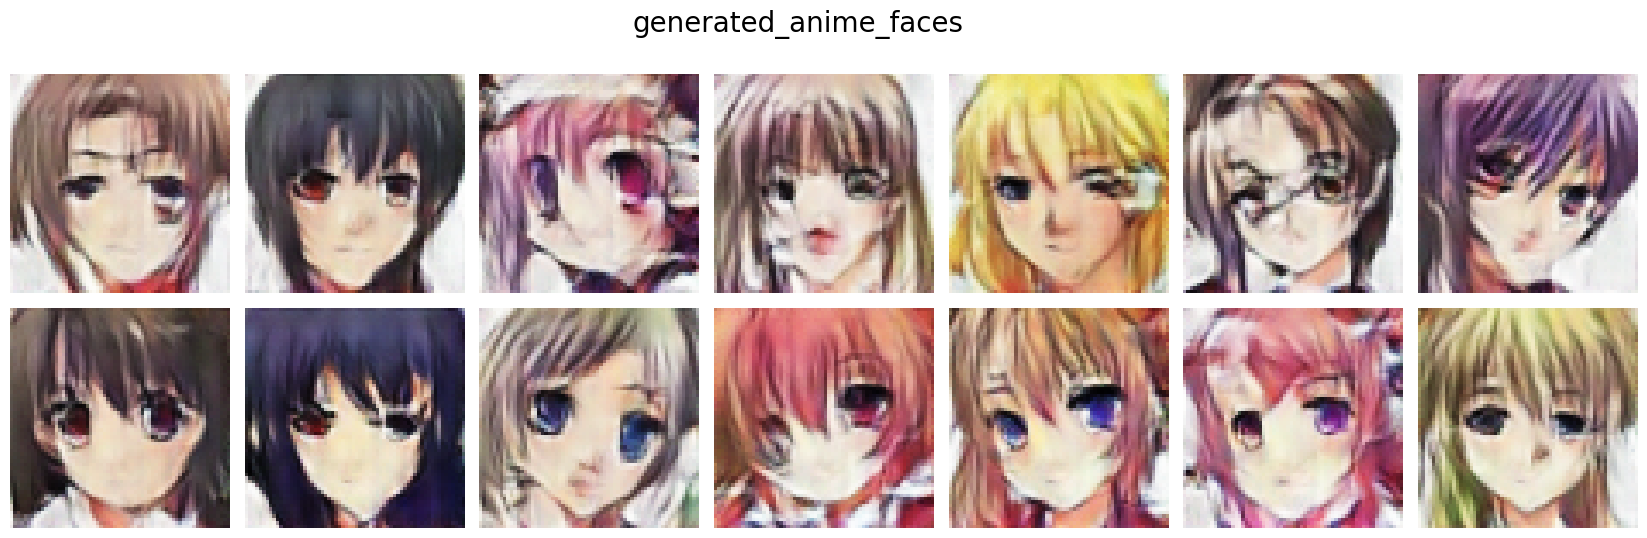

In [21]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder
rows, cols = 2, 7
sample_noise = torch.randn(rows*cols, Z).to(device)
with torch.no_grad():
    generations = generator(sample_noise).cpu()
    generations = (generations + 1) / 2  # setting generations range to [0,1] 
display_image_grid(generations, rows, cols, "generated_anime_faces")

### 🤔 Discussion


As we can see, the generator produces very nice and believable images. It was also able to circumvent the blurriness issue often present in VAEs.

However, GANs have their own challenges:
- **Training Instability**: GANs are notoriously unstable and hard to train. Finding the right hyperparameters and architecture is key. This was less of an issue here due to the relatively small data and a well-established architecture (DCGAN).
- **Mode Collapse**: This is an issue where the generator starts producing only one or a few types of images, failing to capture the full diversity of the dataset.

To resolve some of these issues, more advanced GAN variants like Conditional GANs (cGANs) were introduced, where a condition (like a class label) is passed to the generator along with the noise.

## 🧪 What to Try Next

- Tune Hyperparameters: Experiment with the latent dimension size (Z), learning rate, or batch size to see how they impact training stability and the quality of the generated faces.
- Explore the Latent Space: Create a smooth animation by generating two random noise vectors and interpolating between them. Pass these interpolated vectors to the generator to watch one face morph into another.(Ask claude it will do it for you)
- Modify the Model Architecture: Add or remove ConvTranspose2d/Conv2d layers in the Generator and Discriminator to see how the model's depth affects its ability to generate complex features.
- Train on a Different Dataset: Adapt the model to train on another image dataset, like CelebA (real faces) or CIFAR-10 (objects), and compare the results.

### Contributed by: Ali Habibullah. 